In [147]:
import numpy as np
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import statsmodels.formula.api as sm
import winsound
import timeit
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import datetime
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [2]:
#Variables
defK = 35
defELO = 1200

In [3]:
detsX = pd.read_csv("../input/RegularSeasonDetailedResults.csv")
compX = pd.read_csv("../input/RegularSeasonCompactResults.csv")
tournX = pd.read_csv("../input/TourneyDetailedResults.csv")
compY = pd.read_csv("../input/TourneyCompactResults.csv")
seeds = pd.read_csv("../input/TourneySeeds.csv")
sample = pd.read_csv("../input/sample_submission.csv")

In [4]:
tournX['isTourn']=tournX.apply(lambda row: 1, axis = 1)
detsX['isTourn']=detsX.apply(lambda row: 0, axis = 1)
detsX = detsX.append(tournX)

In [5]:
#Set up ELO basis
detsX['WELO'] = detsX.apply(lambda row: defELO, axis=1)
detsX['LELO'] = detsX.apply(lambda row: defELO, axis=1)


In [6]:
#Engineer Features
detsX['Ptdiff'] = detsX.apply(lambda row: row['Wscore']-row['Lscore'], axis=1)

In [7]:
#Create ELO Scores
##Create initial ELOs for all teams (1200)
#ELOs = pd.concat(compY[['Wteam','Lteam']][compY['Season'] == 2016],compY[['Lteam','Wteam']][compY['Season'] == 2016])
ELOs = compX[['Wteam','Lteam']].append(compX[['Lteam','Wteam']][compX['Season'] == 2016])
ELOs['ELO'] = ELOs.apply(lambda row: defELO, axis=1)
ELOs = ELOs.drop('Lteam', 1)
ELOs['team'] = ELOs['Wteam']
ELOs = ELOs.drop('Wteam', 1)
ELOs = ELOs[['team','ELO']]
ELOs=ELOs.groupby('team').mean()
ELOs['K']=ELOs.apply(lambda row: defK, axis = 1)
ELOs['Sgame']=ELOs.apply(lambda row: 0, axis = 1)
##Account for team churn year-to-year

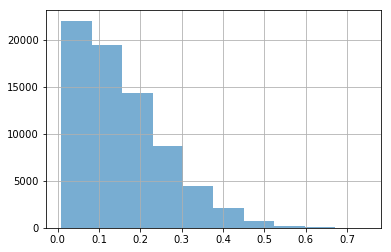

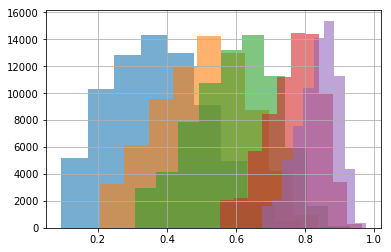

In [8]:
#Visualize how much each team wins by
scoreSer = (detsX['Wscore']-detsX['Lscore'])/detsX['Wscore']
plt.figure(1)
scoreSer.hist(alpha=0.6)
#Expand the lower numbers across greater bounds for normal distributions
plt.figure(2)
(scoreSer**(1/2)).hist(alpha=0.6)
plt.figure(2)
(scoreSer**(1/3)).hist(alpha=0.6)
plt.figure(2)
(scoreSer**(1/4)).hist(alpha=0.6)
plt.figure(2)
(scoreSer**(1/8)).hist(alpha=0.6)
plt.figure(2)
(scoreSer**(1/12)).hist(alpha=0.6)
plt.show()

In [9]:
%%cython
cpdef ELOCalc(double WR_old, double LR_old, int ptDiffPct, double WK=40, double LK=40, str court='N'):
    cdef double K
    cdef double WE
    cdef double LE
    cdef double probW
    cdef double probELO
    
    #Account for home court advantage
    if court == 'H':
        probCourt = 0.655
    elif court == 'A':
        probCourt = 1-0.655
    else:
        probCourt = 0.5
    #Calc prob winner wins
    probELO = WR_old/(WR_old+LR_old)
    #Formula from http://www.mathpages.com/home/kmath267.htm
    probW = (probCourt*probELO)/(probCourt*probELO+(1-probCourt)*(1-probELO))
    #Set K based on W/L K and margin of victory
    K = (WK+LK)/2
    K=7/8*K+1/8*K*ptDiffPct**(1/8)
    WE = WR_old/(WR_old+LR_old)
    LE = LR_old/(WR_old+LR_old)
    WR_new = WR_old + K*(1-probW)
    LR_new = LR_old + K*(0-(1-probW))
    #ELOs.loc[Wteam, 'ELO'] = WR_new
    #ELOs.loc[Lteam, 'ELO'] = LR_new
    return [WR_new, LR_new]

In [10]:
n = 10000
timeit.timeit('ELOCalc(1101,1204,0.08)',number=n, globals=globals())

0.007888679098880066

In [11]:
#Games per season
detsX[['Season','Wteam']][detsX['Season']>2010].groupby('Season').count()/ELOs.ELO.count()

,Wteam
Season,
2011,14.596154
2012,14.615385
2013,14.799451
2014,14.914835
2015,14.892857
2016,14.934066


In [1]:
def winProb(x):
    court = x['Wloc']
    if court == 'H':
        probCourt = 0.655
    elif court == 'A':
        probCourt = 1-0.655
    else:
        probCourt = 0.5
    #Calc prob winner wins
    probELO = x['WELO']/(x['WELO']+x['LELO'])
    probW = (probCourt*probELO)/(probCourt*probELO+(1-probCourt)*(1-probELO))
    if x['Hwon'] == 1:
        return probW
    else:
        return (1-probW)

In [15]:
#detsX.loc[(2016,11, 1104),'Season']

In [16]:
def locReverse(loc):
    if loc == 'A':
        return 'H'
    elif loc == 'H':
        return 'A'
    else:
        return 'N'

In [17]:
##Simulate ELO
##Setup data to ELO
#Time it
start = time.time()

#detsX = detsX.sort_index()

for year in range(2003,2017):
    games = detsX[detsX['Season']==year]
    dayArray = games['Daynum'].unique()
    print(year)
    for day in dayArray:
        for a in games[['Wteam','Lteam','Wloc', 'Wscore', 'Lscore']][(games['Daynum'] == day)].as_matrix():
            #Set Historical ELO
            winPct = (a[3]-a[4])/a[3]
            firstELOs = [ELOs.loc[a[0]].ELO, ELOs.loc[a[1]].ELO]
            detsX.loc[(detsX.Season == year) & (detsX.Daynum == day) & (detsX.Wteam == a[0]),['WELO','LELO']] = (firstELOs)
            #detsX.loc[(year,day,a[0]),['WELO','LELO']] = (firstELOs)
            #Update Ongoing ELO
            ELOUpdate = ELOCalc(firstELOs[0], firstELOs[1], winPct, court=a[2])
            ELOs.loc[a[0], 'ELO'] = ELOUpdate[0]
            ELOs.loc[a[1], 'ELO'] = ELOUpdate[1]


duration = time.time() - start
winsound.Beep(2500,500)


print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
5 Minute(s), 12 Second(s).


In [18]:
#Add ELODiff Metric
detsX['ELODiff'] = detsX.apply(lambda row: row['WELO'] - row['LELO'] , axis=1)

#creating a dataframe of relevant years
useGames = detsX[(detsX['Season']>=2000)]
            
##Create ELO-based dataframe. This will be useful in creating an ML model with consisten team positions
(useGames['Hteam'],useGames['Hscore'],useGames['Hloc'],useGames['Hfgm'],useGames['Hfga'],
 useGames['Hfgm3'],useGames['Hfga3'],useGames['Hfta'],useGames['Hor'],useGames['Hdr'],
 useGames['Hast'],useGames['Hto'],useGames['Hstl'],useGames['Hblk'],useGames['Hpf'],
 useGames['Loteam'],useGames['Loscore'],useGames['Loloc'],useGames['Lofgm'],useGames['Lofga'],
 useGames['Lofgm3'],useGames['Lofga3'],useGames['Lofta'],useGames['Loor'],useGames['Lodr'],
 useGames['Loast'],useGames['Loto'],useGames['Lostl'],useGames['Loblk'],useGames['Lopf'],
 useGames['HELO'],useGames['LoELO'], useGames['PtHDiff'], useGames['Hwon']
) = zip(*useGames.apply(lambda row: 
                       (row['Wteam'],row['Wscore'],row['Wloc'],row['Wfgm'],row['Wfga'],
                        row['Wfgm3'],row['Wfga3'],row['Wfta'],row['Wor'],row['Wdr'],
                        row['Wast'],row['Wto'],row['Wstl'],row['Wblk'],row['Wpf'],
                        row['Lteam'],row['Lscore'],locReverse(row['Wloc']),row['Lfgm'],row['Lfga'],
                        row['Lfgm3'],row['Lfga3'],row['Lfta'],row['Lor'],row['Ldr'],
                        row['Last'],row['Lto'],row['Lstl'],row['Lblk'],row['Lpf'],
                        row['WELO'], row['LELO'], row['Ptdiff'], 1)
                       if row['WELO'] > row['LELO'] else 
                       (row['Lteam'],row['Lscore'],locReverse(row['Wloc']),row['Lfgm'],row['Lfga'],
                        row['Lfgm3'],row['Lfga3'],row['Lfta'],row['Lor'],row['Ldr'],
                        row['Last'],row['Lto'],row['Lstl'],row['Lblk'],row['Lpf'],
                        row['Wteam'],row['Wscore'],row['Wloc'],row['Wfgm'],row['Wfga'],
                        row['Wfgm3'],row['Wfga3'],row['Wfta'],row['Wor'],row['Wdr'],
                        row['Wast'],row['Wto'],row['Wstl'],row['Wblk'],row['Wpf'],
                        row['LELO'],row['WELO'], -row['Ptdiff'], 0),
                       axis=1))

useGames.reset_index(inplace=True)

In [19]:
#Generate expected win % on all past games
#useGames.loc[:,'Hprob'] = useGames.apply(lambda row: row['HELO']/(row['HELO']+row['LoELO']),axis=1)
useGames.loc[:,'Hprob'] = useGames.apply(winProb,axis=1)

#Quick test to see how well ELO is predicting winners
expecteds = useGames[(useGames['Wteam'] == useGames['Hteam']) & (useGames['Season'] >= 2010)].shape[0]
upsets = useGames[(useGames['Wteam'] != useGames['Hteam']) & (useGames['Season'] >= 2010)].shape[0]
accuracy = expecteds/(expecteds+upsets)
print("By ELO Alone:")
print('{} expected teams and {} unexpected teams won for an accuracy of {:.1%}.'.format(expecteds, upsets, accuracy))
expecteds = useGames[(useGames['Hprob'] > 0.5) & (useGames['Season'] >= 2010)].shape[0]
upsets = useGames[(useGames['Hprob'] <= 0.5) & (useGames['Season'] >= 2010)].shape[0]
accuracy = expecteds/(expecteds+upsets)
print("Adding Probability Metric:")
print('{} expected teams and {} unexpected teams won for an accuracy of {:.1%}.'.format(expecteds, upsets, accuracy))

By ELO Alone:
25180 expected teams and 12453 unexpected teams won for an accuracy of 66.9%.
Adding Probability Metric:
26219 expected teams and 11414 unexpected teams won for an accuracy of 69.7%.


In [20]:
a=0
games = detsX[detsX['Season']==2010]
dayArray = games['Daynum'].unique()
print(2010)
for day in dayArray:
    for Wteam, Lteam, Wloc in zip(games['Wteam'][(games['Daynum'] == day)].values.tolist(),
                            games['Lteam'][(games['Daynum'] == day)].values.tolist(),
                                 games['Wloc'][(games['Daynum'] == day)].values.tolist()):
        a=a+1
print(a)

2010
5327


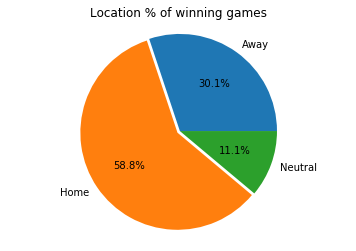

In [21]:
##Checking Away vs Home
labels = ['Away','Home','Neutral']
sizes = [detsX[detsX['Wloc'] == 'A'].shape[0],detsX[detsX['Wloc'] == 'H'].shape[0],detsX[detsX['Wloc'] == 'N'].shape[0]]
plt.pie(sizes,explode=(0,0.03,0),labels=labels,autopct='%1.1f%%')
plt.axis('equal')
plt.title('Location % of winning games')
plt.show()

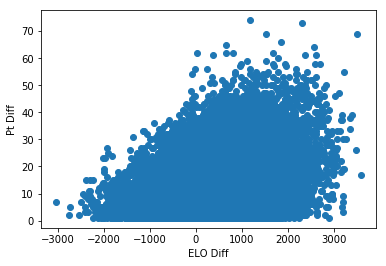

In [22]:
#Checking ELO relevance to ptDiff
x=useGames['ELODiff'][useGames['Season']>2010] #Using onlyu 2011+ data so the ELO is meaningful
y=useGames['Ptdiff'][useGames['Season']>2010]
plt.scatter(x,y)
plt.xlabel('ELO Diff')
plt.ylabel('Pt Diff')
plt.show()

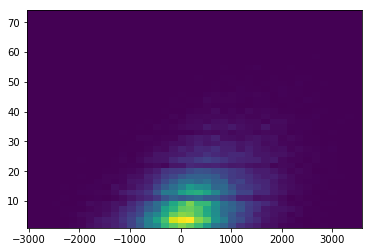

In [23]:
##Scatter plot is too dense, turning it into a heat map
heatmap, xedges, yedges = np.histogram2d(x, y, bins=40)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.show()

Coefficients: 
 [ 0.00404141]
Mean squared error: 72.42
Variance score: 0.12


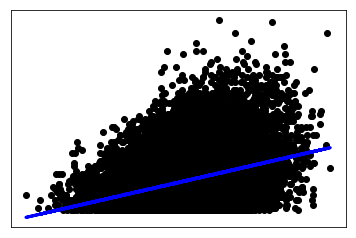

In [24]:
##Looks promising. Let's see how a quick linear regression takes
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
npX = x.as_matrix()[:, np.newaxis]
npY = y.as_matrix()

regr.fit(npX, npY)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(npX) - npY) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(npX, npY))

# Plot outputs
plt.scatter(npX, npY,  color='black')
plt.plot(npX, regr.predict(npX), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [25]:
#More in depth summary statistics on OLS
result = sm.ols(formula="Ptdiff ~ ELODiff", data=useGames[['Ptdiff','ELODiff']]).fit()
print(result.params)
print(result.summary())

Intercept    10.844856
ELODiff       0.004403
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                 Ptdiff   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     7315.
Date:                Sat, 11 Mar 2017   Prob (F-statistic):               0.00
Time:                        11:04:48   Log-Likelihood:            -2.5867e+05
No. Observations:               72155   AIC:                         5.173e+05
Df Residuals:                   72153   BIC:                         5.174e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------

In [26]:
resultHome = sm.ols(formula="Ptdiff ~ ELODiff", data=useGames[['Ptdiff','ELODiff']][useGames['Wloc'] == 'H']).fit()
print(resultHome.params)
print(resultHome.summary())
resultAway = sm.ols(formula="Ptdiff ~ ELODiff", data=useGames[['Ptdiff','ELODiff']][useGames['Wloc'] == 'A']).fit()
print(resultAway.params)
print(resultAway.summary())

Intercept    12.092293
ELODiff       0.005255
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                 Ptdiff   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     5631.
Date:                Sat, 11 Mar 2017   Prob (F-statistic):               0.00
Time:                        11:04:48   Log-Likelihood:            -1.5491e+05
No. Observations:               42418   AIC:                         3.098e+05
Df Residuals:                   42416   BIC:                         3.098e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------

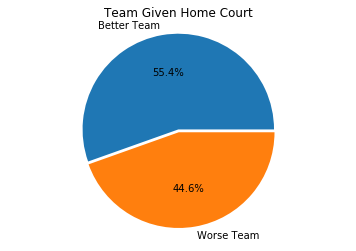

In [27]:
#Home court advantage appears to matter, but are there mitigating factors?
##Is the better team more likely to get home court?
betterHomes = (detsX[(detsX['WELO']>detsX['LELO']) & (detsX['Wloc'] == 'H')].shape[0] + 
               detsX[(detsX['WELO']<detsX['LELO']) & (detsX['Wloc'] == 'A')].shape[0])

worseHomes = (detsX[(detsX['WELO']<detsX['LELO']) & (detsX['Wloc'] == 'H')].shape[0] + 
               detsX[(detsX['WELO']>detsX['LELO']) & (detsX['Wloc'] == 'A')].shape[0])
sizes = [betterHomes, worseHomes]
labels = ['Better Team', 'Worse Team']
plt.pie(sizes,explode=(0,0.03),labels=labels,autopct='%1.1f%%')
plt.axis('equal')
plt.title('Team Given Home Court')
plt.show()

In [28]:
#Calculate ELO-neutral home court advantage 
evenGames = useGames[useGames['LoELO']>0.9*useGames['HELO']]

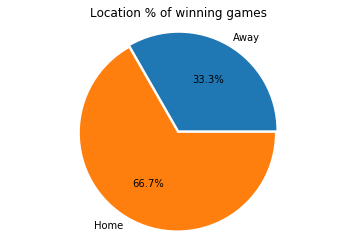

In [29]:
##Checking Away vs Home with evenly-matched teams
labels = ['Away','Home']
sizes = [evenGames[evenGames['Wloc'] == 'A'].shape[0],evenGames[evenGames['Wloc'] == 'H'].shape[0]]
plt.pie(sizes,explode=(0,0.03),labels=labels,autopct='%1.1f%%')
plt.axis('equal')
plt.title('Location % of winning games')
plt.show()

In [30]:
#Non-ELO feature engineering for ML
##H/Lo ELO Trend
def HELOTrend(x):
    x['']



##H/Lo Offensive Score
###Calc previous 10 


##H/Lo Defensive Score

##H/Lo

In [31]:
tournX = useGames[(useGames['isTourn']==1) & (useGames['Season']<2013)]
tournY = useGames[(useGames['isTourn']==1) & (useGames['Season']>=2013)]

In [567]:
target = 'Hwon'

In [568]:
year = 2016
a = useGames[useGames['isTourn']==0][['Season','Wteam','Daynum','isTourn']].groupby(['Season','Wteam']).max()
b = useGames[useGames['isTourn']==0][['Season','Lteam','Daynum','isTourn']].groupby(['Season','Lteam']).max()

In [569]:
a.reset_index(inplace=True)
b.reset_index(inplace=True)

In [570]:
a=pd.merge(a,useGames[['Season','Wteam','Daynum','WELO']],on=['Season','Wteam','Daynum']).drop('isTourn',axis=1)
b=pd.merge(b,useGames[['Season','Lteam','Daynum','LELO']],on=['Season','Lteam','Daynum']).drop('isTourn',axis=1)

In [571]:
a=a.rename(columns={'Daynum': 'DaynumA', 'Wteam': 'team'})
b=b.rename(columns={'Daynum': 'DaynumB', 'Lteam': 'team'})

In [572]:
#Set up a matrix of each team's last win and last loss days before the tournament
c=pd.merge(a,b,on=['Season','team'],how='left')
#accounting for teams with perfect seasons
c=c.fillna(0)

In [573]:
c.head()

,Season,team,DaynumA,WELO,DaynumB,LELO
0,2003,1102,124,1135.494624,129.0,1147.031456
1,2003,1103,121,1204.798551,126.0,1202.225804
2,2003,1104,121,1284.168341,129.0,1283.518366
3,2003,1105,117,1035.004925,124.0,1015.738006
4,2003,1106,124,1169.564829,127.0,1192.295854


In [574]:
c['Daynum']=c.apply(lambda row: row['DaynumA'] if row['DaynumA'] > row['DaynumB'] else row['DaynumB'] ,axis=1)
c['ELO']=c.apply(lambda row: row['WELO'] if row['DaynumA'] > row['DaynumB'] else row['LELO'] ,axis=1)

In [575]:
print(max(c['Daynum']))
print(min(tournX['Daynum']))

132.0
134


In [576]:
##Get a list of stats at by team and year prior to competing ---OBSOLETE
# Wmerge = pd.merge(c,useGames, on=['Season','Wteam','Daynum'])
# Lmerge = pd.merge(c,useGames, on=['Season','Lteam','Daynum'])
# Wmerge = Wmerge.drop([x for x in list(Wmerge) if ('Wteam' in x or 'Lteam' in x)], axis=1)
# Lmerge = Lmerge.drop([x for x in list(Lmerge) if ('Wteam' in x or 'Lteam' in x)], axis=1)
# lastGames = Wmerge.append(Lmerge)

lastGames = c[['Season','team','ELO']]

In [577]:
#Set up the Kaggle Submission
##create a unique list of teams by year
tournTeamsW = compY[['Season','Wteam','Numot']][compY['Season']>=2006].groupby(['Season','Wteam']).aggregate(np.sum)
tournTeamsW = tournTeamsW.reset_index().rename(columns={'Wteam':'team'})

tournTeamsL = compY[['Season','Lteam','Numot']][compY['Season']>=2006].groupby(['Season','Lteam']).aggregate(np.sum)
tournTeamsL = tournTeamsL.reset_index().rename(columns={'Lteam':'team'})

tournTeams = tournTeamsW.append(tournTeamsL)
tournTeams.reset_index(inplace=True, drop=True)
tournTeams = tournTeams.groupby(['Season','team']).sum()
tournTeams.reset_index(inplace=True)
##set up a cartesian join
#tournTeams['JC'] = tournTeams.apply(lambda row: True, axis=1)
tournTeams = pd.merge(tournTeams,lastGames, on=['Season','team'], how='left').drop('Numot',axis=1)

In [578]:
def regToNum(div):
    #div = row['Seed'][0:1]
    if div == 'W':
        return 1
    elif div == 'X':
        return 2
    elif div == 'Y':
        return 3
    else:
        return 4

In [579]:
##########################FEATURE ENGINEER TEAMS HERE#############################
#Add Seeds
tournTeams = pd.merge(tournTeams,seeds,left_on=['Season','team'],right_on=['Season','Team']).drop('Team',axis=1)
#Hot encode seeds
tournTeams = pd.concat([tournTeams.reset_index(drop=True),
                         pd.get_dummies(tournTeams.apply(lambda row: row['Seed'][0:1],axis=1)).reset_index(drop=True)],
                        axis=1)
#Set teams as num value ---Deprecated since Hot Encoding proved better (ceteris paribus 0.594 to 0.579 logloss)
# tournTeams['Div'] = tournTeams.apply(lambda row: regToNum(row['Seed'][0:1]),axis=1)

#Add Seed Spot
tournTeams['SeedNum'] = tournTeams.apply(lambda row: int(row['Seed'][1:3]),axis=1).reset_index(drop=True)

In [580]:
tournTeams = tournTeams.drop('Seed', axis=1)

In [581]:
useGames['HfgEff'] = useGames['Hfgm']/useGames['Hfga']
useGames['LofgEff'] = useGames['Lofgm']/useGames['Lofga']

In [582]:
##Engineer Trends
noTourns = useGames['isTourn']==0
Hteams = useGames[noTourns][['Season','Daynum','Hteam','HELO','HfgEff']].rename(columns=
                                                                      {'Hteam':'team','HELO':'ELO', 'HfgEff':'fgEff'})
Loteams = useGames[noTourns][['Season','Daynum','Loteam','LoELO','LofgEff']].rename(columns=
                                                                          {'Loteam':'team','LoELO':'ELO', 'LofgEff':'fgEff'})
trend = Hteams.append(Loteams).sort_values(['Season','Daynum']).reset_index(drop=True)

In [583]:
Eff = trend[['Season','team','fgEff']].groupby(['Season','team']).mean().reset_index()
tournTeams = pd.merge(tournTeams,Eff, on=['Season','team'])

In [584]:
maxSeasDays = max(useGames['Daynum'])
trend['combYr'] = trend.apply(lambda row: 
                              datetime.datetime(
                                  int(row['Season']),(int(row['Daynum'])//27)+1,int(row['Daynum'])%27+1
                              )
                              ,axis=1)
trend['absNum'] = trend.apply(lambda row: 
                              (row['Season']-2000)*maxSeasDays + row['Daynum']
                              ,axis=1)

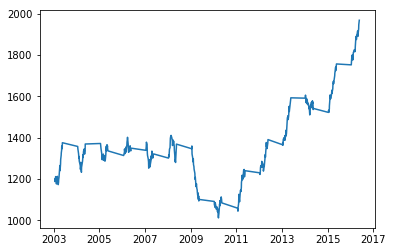

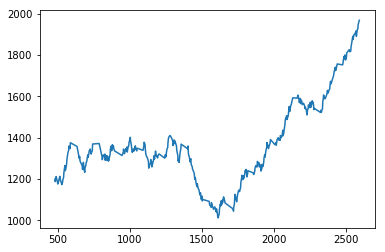

In [585]:
select = trend['team']==1434
plt.plot(trend[select]['combYr'],trend[select]['ELO'])
plt.show()
select = trend['team']==1434
plt.plot(trend[select]['absNum'],trend[select]['ELO'])
plt.show()

In [586]:
#I think I'll be doing this more... making a function
regr = linear_model.LinearRegression()

def seriesRegr(X_Series, Y_Series, plot=False):
    npX = X_Series.as_matrix()[:, np.newaxis]
    npY = Y_Series.as_matrix()
    regr.fit(npX, npY)
    if plot:
        # The coefficients
        print('Coefficients: \n', regr.coef_)
        # The mean squared error
        print("Mean squared error: %.2f"
              % np.mean((regr.predict(npX) - npY) ** 2))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % regr.score(npX, npY))

        # Plot outputs
        plt.scatter(npX, npY,  color='black')
        plt.plot(npX, regr.predict(npX), color='blue',
                 linewidth=3)

        plt.xticks(())
        plt.yticks(())

        plt.show()
    return [regr.coef_[0],regr.score(npX, npY)]

def regApply(Season, Team, Years=2):
    select = (trend['Season']>(Season-Years)) & (trend['Season']<=Season) & (trend['team']==Team)
    X_Series = trend['absNum'][select]
    Y_Series = trend['ELO'][select]
    return seriesRegr(X_Series, Y_Series)

Coefficients: 
 [ 0.86328671]
Mean squared error: 2247.07
Variance score: 0.96


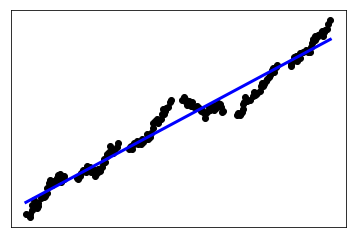

[0.86328670931244234, 0.95848415017540645]

In [587]:
seriesRegr(trend['absNum'][(select) & (trend['Season']>2010)],trend['ELO'][(select) & (trend['Season']>2010)],True)

In [588]:
result = sm.ols(formula="ELO ~ absNum", data=trend[(select) & (trend['Season']>2010)]).fit()
print(result.params)
print(result.summary())

Intercept   -359.123681
absNum         0.863287
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    ELO   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     4225.
Date:                Sat, 11 Mar 2017   Prob (F-statistic):          2.22e-128
Time:                        20:26:49   Log-Likelihood:                -976.36
No. Observations:                 185   AIC:                             1957.
Df Residuals:                     183   BIC:                             1963.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------

In [589]:
(tournTeams['trend'],
 tournTeams['Var']) = zip(*tournTeams.apply(lambda row: 
                                            (regApply(row['Season'], row['team'])[0],
                                             regApply(row['Season'], row['team'])[1]),
                                             axis=1
                                           )
                         )

In [590]:
list(useGames)

['index',
 'Season',
 'Daynum',
 'Wteam',
 'Wscore',
 'Lteam',
 'Lscore',
 'Wloc',
 'Numot',
 'Wfgm',
 'Wfga',
 'Wfgm3',
 'Wfga3',
 'Wftm',
 'Wfta',
 'Wor',
 'Wdr',
 'Wast',
 'Wto',
 'Wstl',
 'Wblk',
 'Wpf',
 'Lfgm',
 'Lfga',
 'Lfgm3',
 'Lfga3',
 'Lftm',
 'Lfta',
 'Lor',
 'Ldr',
 'Last',
 'Lto',
 'Lstl',
 'Lblk',
 'Lpf',
 'isTourn',
 'WELO',
 'LELO',
 'Ptdiff',
 'ELODiff',
 'Hteam',
 'Hscore',
 'Hloc',
 'Hfgm',
 'Hfga',
 'Hfgm3',
 'Hfga3',
 'Hfta',
 'Hor',
 'Hdr',
 'Hast',
 'Hto',
 'Hstl',
 'Hblk',
 'Hpf',
 'Loteam',
 'Loscore',
 'Loloc',
 'Lofgm',
 'Lofga',
 'Lofgm3',
 'Lofga3',
 'Lofta',
 'Loor',
 'Lodr',
 'Loast',
 'Loto',
 'Lostl',
 'Loblk',
 'Lopf',
 'HELO',
 'LoELO',
 'PtHDiff',
 'Hwon',
 'Hprob',
 'HfgEff',
 'LofgEff']

In [591]:
#Verify all tournament teams are represented
tournTeams.groupby('Season').count()

,team,ELO,W,X,Y,Z,SeedNum,fgEff,trend,Var
Season,,,,,,,,,,
2006,65,65,65,65,65,65,65,65,65,65
2007,65,65,65,65,65,65,65,65,65,65
2008,65,65,65,65,65,65,65,65,65,65
2009,65,65,65,65,65,65,65,65,65,65
2010,65,65,65,65,65,65,65,65,65,65
2011,68,68,68,68,68,68,68,68,68,68
2012,68,68,68,68,68,68,68,68,68,68
2013,68,68,68,68,68,68,68,68,68,68
2014,68,68,68,68,68,68,68,68,68,68


In [592]:
def winPct(Season, Team):
    select = (useGames['isTourn']==0) & (useGames['Season']==Season)
    Wgames = useGames[select & (useGames['Wteam']==Team)].shape[0]
    Lgames = useGames[select & (useGames['Lteam']==Team)].shape[0]
    pct = Wgames/(Wgames+Lgames)
    return pct

def fgEffStd(Season, Team):
    select = (trend['Season']==Season) & (trend['Season']==Season)
    trend[select]['fgEff']

In [593]:
tournTeams['winPct'] = tournTeams.apply(lambda row:
                winPct(row['Season'],row['team'])
                ,axis=1)

In [618]:
EffStdtrend[['fgEff','Season','team']].groupby(['Season','team']).std().reset_index().rename(columns={'fgEff':'fgEffStd'})

,Season,team,fgEffStd
0,2003,1102,0.112837
1,2003,1103,0.076162
2,2003,1104,0.074775
3,2003,1105,0.065716
4,2003,1106,0.074822
5,2003,1107,0.064495
6,2003,1108,0.065446
7,2003,1110,0.063567
8,2003,1111,0.082347
9,2003,1112,0.054280


In [594]:
#create matchups
tourns = useGames[useGames['isTourn']==1]
matchups=pd.merge(tournTeams,tournTeams,on='Season')
matchups = matchups[matchups['ELO_x']>matchups['ELO_y']]
matchups.reset_index(inplace=True, drop=True)

In [595]:
##########################FEATURE ENGINEER MATCHUPS HERE###################################
matchups['Hprob']=matchups.apply(lambda row: row['ELO_x']/(row['ELO_x']+row['ELO_y']),axis=1)
matchups['SeedDiff1'] = matchups.apply(lambda row: row['SeedNum_x']-row['SeedNum_y'],axis=1)
matchups['SeedDiff2'] = matchups.apply(lambda row: row['SeedNum_x']/row['SeedNum_y'],axis=1)
matchups['fgEffDiff1'] = matchups.apply(lambda row: row['fgEff_x']-row['fgEff_y'],axis=1)
matchups['fgEffDiff2'] = matchups.apply(lambda row: row['fgEff_x']/row['fgEff_y'],axis=1)
#matchups['SeedDiff2'] = matchups.apply(lambda row: (row['SeedNum_x']/row['SeedNum_y'])**(2),axis=1)

In [596]:
test=matchups[matchups['Season']>=2013]

In [597]:
matchups = pd.merge(matchups,tourns[['Hteam','Loteam','Season','Hwon']],
                    left_on=['Season','team_x','team_y'],
                    right_on=['Season','Hteam','Loteam'])
matchups=matchups.drop(['Hteam','Loteam'],axis=1)

In [598]:
matchups.shape

(716, 29)

In [599]:
train=matchups[matchups['Season']<2013]
testLocal=matchups[matchups['Season']>=2013] #--Set submission before adding Hwon

In [600]:
train.dtypes

Season          int64
team_x          int64
ELO_x         float64
W_x             uint8
X_x             uint8
Y_x             uint8
Z_x             uint8
SeedNum_x       int64
fgEff_x       float64
trend_x       float64
Var_x         float64
winPct_x      float64
team_y          int64
ELO_y         float64
W_y             uint8
X_y             uint8
Y_y             uint8
Z_y             uint8
SeedNum_y       int64
fgEff_y       float64
trend_y       float64
Var_y         float64
winPct_y      float64
Hprob         float64
SeedDiff1     float64
SeedDiff2     float64
fgEffDiff1    float64
fgEffDiff2    float64
Hwon            int32
dtype: object


Model Report
Accuracy : 0.8641
LogLoss Score (Train): 0.411658


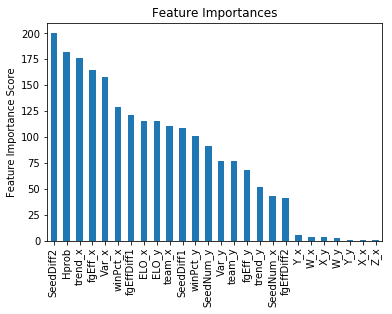

In [652]:
#https://github.com/dmlc/xgboost/blob/master/doc/parameter.md -- for reference

# predictors = [x for x in list(train) if x not in ['Season', 'team_x' ,'team_y', 'Hwon']]
predictors = [x for x in list(train) if x not in ['Season', 'Hwon']]
#predictors = ['Hprob','SeedDiff1', 'SeedDiff2', 'ELO_x', 'fgEffDiff1', 'fgEffDiff2']
# xgb1 = XGBClassifier(
#  learning_rate =0.09,
#  n_estimators=25,
#  max_depth=3,
#  min_child_weight=1,
#  gamma=1,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)

alg = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1, #Given discrepancy between train and test scores, increasing conservative scoring
 reg_lambda=1,
 objective='binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

#####################################################
dtrain = train
useTrainCV=True
cv_folds=5
early_stopping_rounds=50

if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='logloss', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])

#Fit the algorithm on the data
alg.fit(dtrain[predictors], dtrain['Hwon'],eval_metric='logloss')

#Predict training set:
dtrain_predictions = alg.predict(dtrain[predictors])
dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Hwon'].values, dtrain_predictions))
print("LogLoss Score (Train): %f" % metrics.log_loss(dtrain['Hwon'], dtrain_predprob))

feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()


In [653]:
dtrain_predictions = alg.predict(testLocal[predictors])
dtrain_predprob = alg.predict_proba(testLocal[predictors])[:,1]
print("LogLoss Score (Train): %f" % metrics.log_loss(testLocal['Hwon'], dtrain_predprob))

LogLoss Score (Train): 0.571095


In [603]:
dtrain_predictions = alg.predict(test[predictors])
dtrain_predprob = alg.predict_proba(test[predictors])[:,1]

In [604]:
submission=test[['Season', 'team_x','team_y']]
submission.reset_index(drop=True,inplace=True)
submission=pd.concat([submission,pd.Series(dtrain_predprob.tolist())],axis=1)
submission = submission.rename(columns={0:'pred'})

In [605]:
(submission['team1'],
 submission['team2'],
 submission['pred']) = zip(*submission.apply(lambda row: (row['team_x'], row['team_y'], row['pred']) 
                                             if row['team_x']<row['team_y'] else
                                             (row['team_y'],row['team_x'],1-row['pred'])
                                             ,axis=1))

In [606]:
submission['id'] = submission.apply(lambda row: 
                                    str(int(row['Season'])) + 
                                    '_' + str(int(row['team1'])) + 
                                    '_' + str(int(row['team2']))
                                    ,axis=1)

In [607]:
submission[['id','pred']].to_csv('../output/SecondPreds.csv', index=False)

In [608]:
submission[['id','pred']].shape

(9112, 2)

In [ ]:
######################Random Forest######################

In [620]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [654]:
clf = RandomForestClassifier(n_jobs=2)
clf.fit(dtrain[predictors],dtrain['Hwon'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [659]:
clf.predict(testLocal[predictors])

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1])

In [662]:
clf.predict_log_proba(testLocal[predictors])

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:628: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


array([[-0.69314718, -0.69314718],
       [-2.30258509, -0.10536052],
       [-0.10536052, -2.30258509],
       [-0.51082562, -0.91629073],
       [-0.22314355, -1.60943791],
       [-2.30258509, -0.10536052],
       [-2.30258509, -0.10536052],
       [-1.2039728 , -0.35667494],
       [-0.91629073, -0.51082562],
       [-2.30258509, -0.10536052],
       [       -inf,  0.        ],
       [-2.30258509, -0.10536052],
       [-1.60943791, -0.22314355],
       [       -inf,  0.        ],
       [       -inf,  0.        ],
       [-1.60943791, -0.22314355],
       [-1.2039728 , -0.35667494],
       [-1.2039728 , -0.35667494],
       [-0.22314355, -1.60943791],
       [       -inf,  0.        ],
       [       -inf,  0.        ],
       [-2.30258509, -0.10536052],
       [-1.2039728 , -0.35667494],
       [-0.69314718, -0.69314718],
       [-0.69314718, -0.69314718],
       [-1.60943791, -0.22314355],
       [-2.30258509, -0.10536052],
       [-2.30258509, -0.10536052],
       [-2.30258509,

In [664]:
submision

0.93233877420425415

In [ ]:
###############################NEVADA STATE LINES#######################

In [667]:
print("LogLoss Score (Train): %f" % metrics.log_loss(testLocal['Hwon'], testLocal['ELO_x']/(testLocal['ELO_x']+testLocal['ELO_y'])))

LogLoss Score (Train): 0.603921


In [665]:
testLocal

,Season,team_x,ELO_x,W_x,X_x,Y_x,Z_x,SeedNum_x,fgEff_x,trend_x,...,fgEff_y,trend_y,Var_y,winPct_y,Hprob,SeedDiff1,SeedDiff2,fgEffDiff1,fgEffDiff2,Hwon
449,2013,1112,2436.912050,0,0,0,1,6,0.452612,1.074746,...,0.499068,1.174203,0.963258,0.800000,0.517758,-5.0,0.545455,-0.046456,0.906914,1
450,2013,1112,2436.912050,0,0,0,1,6,0.452612,1.074746,...,0.484046,1.017647,0.825211,0.666667,0.599111,-8.0,0.428571,-0.031434,0.935060,1
451,2013,1129,1443.483084,0,0,0,1,13,0.449604,-0.073309,...,0.451881,1.452588,0.948559,0.700000,0.514624,0.0,1.000000,-0.002277,0.994960,0
452,2013,1139,2714.422037,1,0,0,0,6,0.450587,0.430055,...,0.455445,1.387838,0.978034,0.843750,0.607781,-5.0,0.545455,-0.004858,0.989333,1
453,2013,1139,2714.422037,1,0,0,0,6,0.450587,0.430055,...,0.467484,1.188406,0.956467,0.741935,0.521676,3.0,2.000000,-0.016897,0.963856,0
454,2013,1166,2435.563804,0,0,1,0,7,0.510502,1.541836,...,0.400176,1.329303,0.922679,0.666667,0.553867,-3.0,0.700000,0.110326,1.275693,1
455,2013,1181,3704.424772,0,0,1,0,2,0.479180,1.046263,...,0.438120,0.781194,0.900682,0.705882,0.766763,-13.0,0.133333,0.041060,1.093720,1
456,2013,1181,3704.424772,0,0,1,0,2,0.479180,1.046263,...,0.510502,1.541836,0.955940,0.794118,0.603328,-5.0,0.285714,-0.031322,0.938645,1
457,2013,1181,3704.424772,0,0,1,0,2,0.479180,1.046263,...,0.445458,1.446175,0.940316,0.852941,0.557280,1.0,2.000000,0.033722,1.075701,0
458,2013,1181,3704.424772,0,0,1,0,2,0.479180,1.046263,...,0.465485,1.341779,0.968066,0.750000,0.576883,-1.0,0.666667,0.013695,1.029421,1
